# Taxi Tip Prediction using Scikit-Learn and Snap ML

## Objectives

After completing this lab you will be able to:

* Perform basic data preprocessing using Scikit-Learn
* Model a regression task using the Scikit-Learn and Snap ML Python APIs
* Train a Decision Tree Regressor model using Scikit-Learn and Snap ML
* Run inference and assess the quality of the trained models

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 10px">
    <ol>
        <li><a href="#introduction">Introduction</a></li>
        <li><a href="#import_libraries">Import Libraries</a></li>
        <li><a href="#dataset_analysis">Dataset Analysis</a></li>
        <li><a href="#dataset_preprocessing">Dataset Preprocessing</a></li>
        <li><a href="#dataset_split">Dataset Train/Test Split</a></li>
        <li><a href="#dt_sklearn">Build a Decision Tree Regressor model with Scikit-Learn</a></li>
        <li><a href="#dt_snap">Build a Decision Tree Regressor model with Snap ML</a></li>
        <li><a href="#dt_sklearn_snap">Evaluate the Scikit-Learn and Snap ML Decision Tree Regressors</a></li>
    </ol>
</div>
<br>
<hr>


# Import Libraries

In [1]:
# Snap ML is available on PyPI. To install it simply run the pip command below.
!pip install snapml

In [5]:
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

## Load data

In [3]:
df=pd.read_csv("D:\\IBM_Data_Science\\Data_set\\yellow_tripdata_2019-06.csv\\yellow_tripdata_2019-06.csv")

In [4]:
print("There are " + str(len(df)) + " observations in the dataset.")
print("There are " + str(len(df.columns)) + " variables in the dataset.")

There are 6941024 observations in the dataset.
There are 18 variables in the dataset.


In [6]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1,0.0,1,N,262,263,2,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1,4.4,1,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0,0.8,1,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1,1.7,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


***Description dataset:*** Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables. One variable is called tip_amount and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the tip_amount variable. Let's first clean the dataset and retrieve basic statistics about the target variable.

### Clearning Data

There are 4776058 observations in the dataset.
There are 17 variables in the dataset.


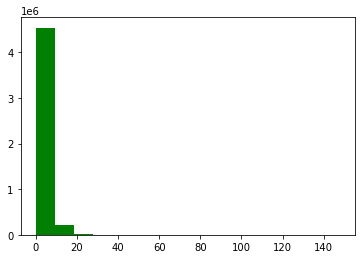

Minimum amount value is  0.01
Maximum amount value is  148.0
90% of the trips have a tip amount less or equal than  5.96


In [7]:
# some trips report 0 tip. it is assumed that these tips were paid in cash.
# for this study we drop all these rows
df = df[df['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was larger than the fare cost
df = df[(df['tip_amount'] <= df['fare_amount'])]

# we remove trips with very large fare cost
df = df[((df['fare_amount'] >=2) & (df['fare_amount'] < 200))]

# we drop variables that include the target variable in it, namely the total_amount
clean_df = df.drop(['total_amount'], axis=1)

# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del df
gc.collect()

# print the number of trips left in the dataset
print("There are " + str(len(clean_df)) + " observations in the dataset.")
print("There are " + str(len(clean_df.columns)) + " variables in the dataset.")

plt.hist(clean_df.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_df.tip_amount.values))
print("Maximum amount value is ", np.max(clean_df.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_df.tip_amount.values, 90))

In [28]:
# display first rows in the dataset
clean_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1,1.70,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2,1.60,1,N,79,125,1,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2,1.20,1,N,79,249,1,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1,8.60,1,N,186,243,1,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1,1.74,1,N,107,148,1,11.0,0.5,0.5,2.96,0.0,0.3,2.5


## EDA

### Descriptive Satictis

In [8]:
clean_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VendorID,4776058.0,1.644097,0.501560,1.00,1.00,2.00,2.00,4.00
passenger_count,4776058.0,1.556244,1.207352,0.00,1.00,1.00,2.00,9.00
trip_distance,4776058.0,3.099333,3.923603,0.00,1.03,1.70,3.16,108.06
RatecodeID,4776058.0,1.054724,0.384804,1.00,1.00,1.00,1.00,99.00
PULocationID,4776058.0,164.071707,65.777440,1.00,125.00,162.00,234.00,265.00
DOLocationID,4776058.0,162.499155,69.792452,1.00,113.00,162.00,234.00,265.00
payment_type,4776058.0,1.000053,0.008633,1.00,1.00,1.00,1.00,4.00
fare_amount,4776058.0,13.673298,11.882981,2.00,7.00,10.00,15.00,199.50
extra,4776058.0,1.205643,1.282690,-26.50,0.00,0.50,2.50,18.50
mta_tax,4776058.0,0.497547,0.038355,0.00,0.50,0.50,0.50,30.80


### Checking clean data (clear_df)

In [9]:
clean_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge'],
      dtype='object')

In [10]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4776058 entries, 4 to 6941023
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   RatecodeID             int64  
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  congestion_surcharge   float64
dtypes: float64(8), int64(6), object(3)
memory usage: 655.9+ MB


In [11]:
clean_df.isnull().sum()# sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
congestion_surcharge     0
dtype: int64

***Check distribution(tip_amount)***

<AxesSubplot:xlabel='tip_amount', ylabel='Density'>

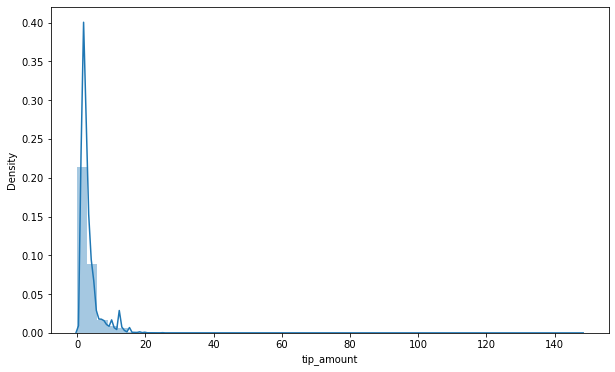

In [12]:
plt.figure(figsize=(10,6))
sns.distplot(clean_df['tip_amount'])

***Check distribution(fare_amount)***

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

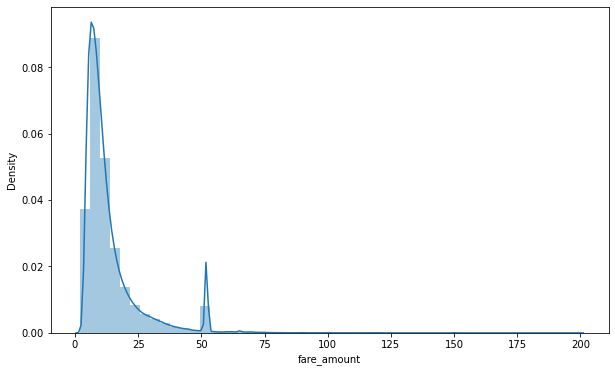

In [13]:
plt.figure(figsize=(10,6))
sns.distplot(clean_df['fare_amount'])

<AxesSubplot:xlabel='fare_amount', ylabel='passenger_count'>

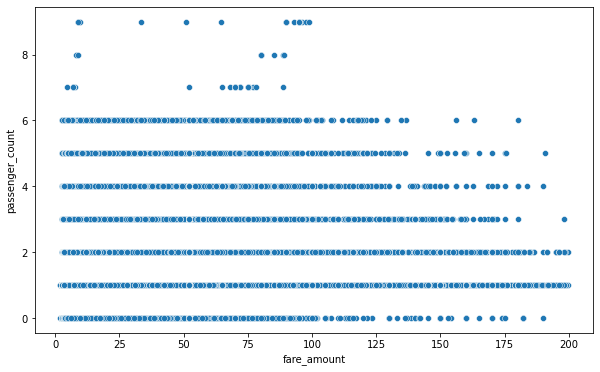

In [14]:

plt.figure(figsize=(10,6))
sns.scatterplot(x='fare_amount',y='passenger_count',data=clean_df,palette="Paired")

<AxesSubplot:xlabel='tip_amount', ylabel='passenger_count'>

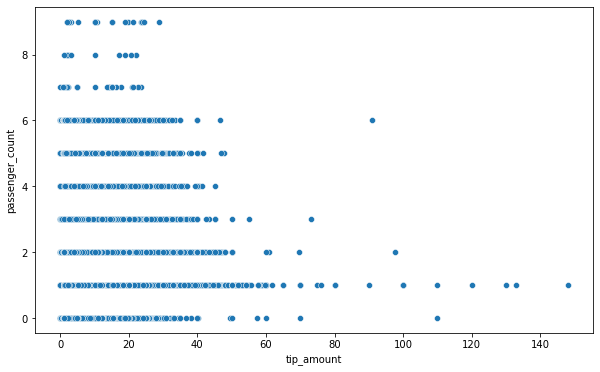

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='tip_amount',y='passenger_count',data=clean_df,palette="rocket")

<Figure size 720x432 with 0 Axes>

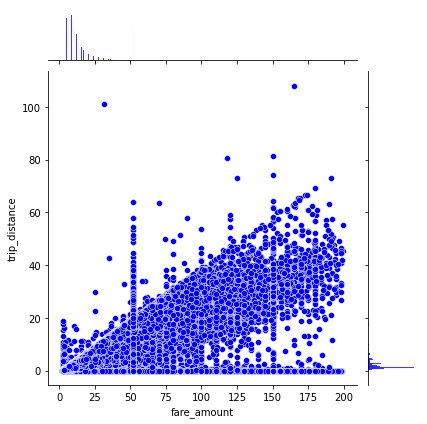

In [16]:
plt.figure(figsize=(10,6))
sns.jointplot(x='fare_amount',y='trip_distance',data=clean_df,color="blue")

<Figure size 720x432 with 0 Axes>

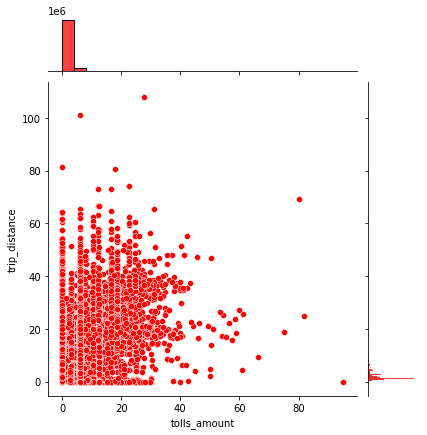

In [17]:
plt.figure(figsize=(10,6))
sns.jointplot(x='tolls_amount',y='trip_distance',data=clean_df,color="red")

<Figure size 720x432 with 0 Axes>

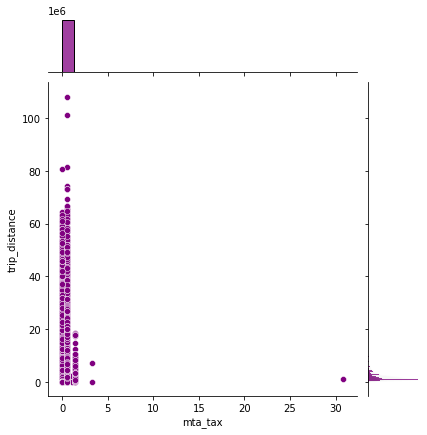

In [18]:

plt.figure(figsize=(10,6))
sns.jointplot(x='mta_tax',y='trip_distance',data=clean_df,color="purple")

<AxesSubplot:>

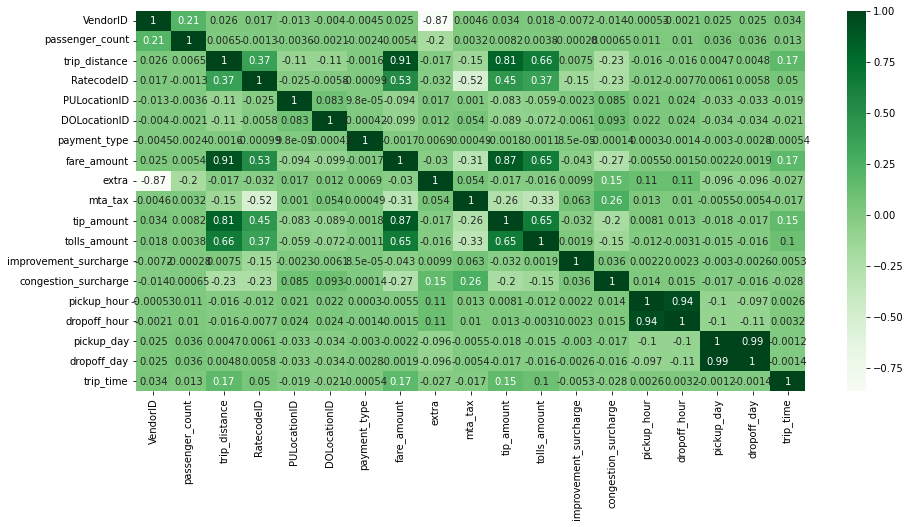

In [21]:
plt.figure(figsize=(15,7))
sns.heatmap(clean_df.corr(),annot=True,cmap="Greens")

In [22]:
clean_df.corr()['tolls_amount'].sort_values()


mta_tax                 -0.331463
congestion_surcharge    -0.153466
DOLocationID            -0.071614
PULocationID            -0.058660
dropoff_day             -0.016031
extra                   -0.015843
pickup_day              -0.015200
pickup_hour             -0.012344
dropoff_hour            -0.003143
payment_type            -0.001064
improvement_surcharge    0.001854
passenger_count          0.003760
VendorID                 0.017879
trip_time                0.103394
RatecodeID               0.371627
tip_amount               0.653159
fare_amount              0.654252
trip_distance            0.655462
tolls_amount             1.000000
Name: tolls_amount, dtype: float64

* Before actually training a ML model, we will need to preprocess the data. We need to transform the data in a format that will be correctly handled by the models.

# Dataset Preprocessing

In this subsection you will prepare the data for training

In [23]:
clean_df['tpep_dropoff_datetime'] = pd.to_datetime(clean_df['tpep_dropoff_datetime'])
clean_df['tpep_pickup_datetime'] = pd.to_datetime(clean_df['tpep_pickup_datetime'])

# extract pickup and dropoff hour
clean_df['pickup_hour'] = clean_df['tpep_pickup_datetime'].dt.hour
clean_df['dropoff_hour'] = clean_df['tpep_dropoff_datetime'].dt.hour

# extract pickup and dropoff day of week
clean_df['pickup_day'] = clean_df['tpep_pickup_datetime'].dt.weekday
clean_df['dropoff_day'] = clean_df['tpep_dropoff_datetime'].dt.weekday

# compute trip time in minutes
clean_df['trip_time'] = (clean_df['tpep_dropoff_datetime'] - clean_df['tpep_pickup_datetime']).astype('timedelta64[m]')

# ideally use the full dataset for this exercise
# however if you run into out of memory issues due to the data size, reduce it
# for instance, in this example we use only the first 1M samples
first_n_rows = 1000000
clean_df = clean_df.head(first_n_rows)

In [24]:
# drop the pickup and dropoff datetimes
clean_df = clean_df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_df = pd.get_dummies(clean_df, columns = get_dummy_col)

# release memory occupied by clean_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del clean_df
gc.collect()

120

In [25]:
# extract the labels from the dataframe
y = proc_df[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_df = proc_df.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_df.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (1000000, 574) y.shape= (1000000, 1)


## Dataset Train/Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (700000, 574) Y_train.shape= (700000, 1)
X_test.shape= (300000, 574) Y_test.shape= (300000, 1)


## Build a Decision Tree Regressor model with Scikit-Learn

In [29]:
# import the Decision Tree Regressor Model from Snap ML
from snapml import DecisionTreeRegressor

# in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training 
# to use the GPU, one needs to set the use_gpu parameter to True
# snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, one needs to set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

# train a Decision Tree Regressor model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  47.93265


In [ ]:
conda install -c anaconda scikit-learn 

In [30]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference using the sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

NameError: name 'sklearn_time' is not defined